# Dealing With Credit Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sys

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

from typing import List, Dict

In [2]:
seed = 0

In [3]:
dataset = pd.read_csv("./credit-dataset.csv")

In [4]:
dataset.head()

,customer_id,customer_age,months_at_address,residence_status,employment,income,months_with_bank,other_credits,balance,status
0,1,53,62,Tenant,Unknown,50000,55,Yes,1055.90,0
1,2,61,22,HomeOwner,Employed,52000,25,Yes,1161.60,0
2,3,47,30,Tenant,Employed,37000,61,No,877.23,0
3,4,50,75,HomeOwner,Employed,53000,20,Yes,157.37,0
4,5,68,56,HomeOwner,Employed,53000,14,Yes,561.84,0


## <font style="color: crimson">TODO:</font> Make a detailed EDA

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        1200 non-null   int64  
 1   customer_age       1200 non-null   int64  
 2   months_at_address  1200 non-null   int64  
 3   residence_status   1200 non-null   object 
 4   employment         1200 non-null   object 
 5   income             1200 non-null   int64  
 6   months_with_bank   1200 non-null   int64  
 7   other_credits      1200 non-null   object 
 8   balance            1200 non-null   float64
 9   status             1200 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 93.9+ KB


In [6]:
dataset.describe()

,customer_id,customer_age,months_at_address,income,months_with_bank,balance,status
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,600.500000,45.174167,41.930833,39317.500000,34.243333,803.111625,0.330833
std,346.554469,9.834265,29.902807,8268.938255,25.189506,587.587021,0.470709
min,1.000000,21.000000,2.000000,18000.000000,2.000000,0.210000,0.000000
25%,300.750000,38.000000,19.000000,34000.000000,14.000000,337.492500,0.000000
50%,600.500000,45.000000,36.000000,39000.000000,28.000000,711.685000,0.000000
75%,900.250000,52.000000,58.000000,45000.000000,49.000000,1137.275000,1.000000
max,1200.000000,74.000000,207.000000,62000.000000,128.000000,3812.000000,1.000000


## Preprocessing

First we are going to split our data into indepentent and depentent variables, in this case, using the raw data. After that, we need to drop the columns that we don't need, keep in mind that we'll be using `sklearn.pipeline`, so we have to create our custom transformers with a `transform` and `fit` method. Finally, categorize continuous variables into bins and use the one-hot encoding technique.

In [7]:
class ColumnSelectorTransformer:
    def __init__(self, columns: List[str]):
        self.columns = columns
    
    def transform(self, X: pd.DataFrame, y: pd.DataFrame = None) -> pd.DataFrame:
        return X.loc[:, self.columns]
    
    def fit(self, *args, **kwargs): 
        return self
    
    def __str__(self) -> str:
        return f"ColumnSelectorTransformer({self.columns})"
    
    def __repr__(self) -> str:
        return f"ColumnSelectorTransformer({self.columns})"
    

class BinningTransformer:
    def __init__(self, bins: Dict):
        self.bins = bins
        
    def __find_bin(self, value: float, mappings: List):
        for mapping in mappings:
            if value <= mapping["max"]:
                return mapping["label"]
        return "Error"
        
    def transform(self, X: pd.DataFrame, y: pd.DataFrame = None) -> pd.DataFrame:
        X = X.copy()
        for key in self.bins.keys():
            X.loc[:, key] = X.loc[:, key].transform(lambda x: self.__find_bin(x, self.bins[key]))
        return X

    def fit(self, *args, **kwargs):
        return self
    
    def __str__(self) -> str:
        return "BinningTransformer()"
    
    def __repr__(self) -> str:
        return "BinningTransformer()"

    
class WOETransformer:
    def __init__(self, columns: List[str], target_mappings: Dict = {0: "good", 1: "bad"}):
        self.target_mappings = target_mappings
        self.columns = columns
        self.woe_mappings = None
    
    def __get_absolute_odds(self, df: pd.DataFrame, col: str):
        key_first, key_second = list(self.target_mappings.keys())
        return (
            df.query(f"status=={key_first}")
            .groupby(col).size().reset_index()
            .rename(columns={0: self.target_mappings[key_first]})
            .set_index(col)
        ).join(
            df.query(f"status=={key_second}")
            .groupby(col).size().reset_index()
            .rename(columns={0: self.target_mappings[key_second]})
            .set_index(col)
        ).reset_index()[[col, "good", "bad"]]

    @staticmethod
    def __calculate_relative_odds(row: pd.Series, total_good: int, total_bad: int) -> pd.Series:
        return pd.Series(
            {
                **row.to_dict(),
                "good": row["good"] / total_good,
                "bad": row["bad"] / total_bad
            }
        )

    def __get_odds(self, df: pd.DataFrame, col: str,
                   absolute_values: bool = False) -> pd.DataFrame:
        key_first, key_second = list(self.target_mappings.keys())
        odds_absolute = self.__get_absolute_odds(df, col)

        if absolute_values:
            return odds_absolute

        # Relative Odds
        total_good = odds_absolute["good"].sum()
        total_bad = odds_absolute["bad"].sum()
        return odds_absolute.apply(
            lambda row: WOETransformer.__calculate_relative_odds(row, total_good, total_bad),
            axis=1
        )

    @staticmethod
    def __calculate_woe(row: pd.Series) -> pd.Series:
        return pd.Series(
            {
                **row.to_dict(),
                "woe": np.log(row["good"] / row["bad"]),
                "info_val": (row["good"] - row["bad"]) * np.log(row["good"] / row["bad"])
            }
        )

    def __set_woe_mappings(self, X: pd.DataFrame, y: pd.Series,
                           absolute_values: bool = False) -> None:
        df = X.copy()
        df["status"] = y
        
        self.woe_mappings = {
            col: self.__get_odds(df, col, absolute_values)\
                .apply(lambda row: WOETransformer.__calculate_woe(row), axis=1)\
                .sort_values(by="woe", axis=0, ascending=True)
            for col in self.columns
        }
        
    def fit(self, X: pd.DataFrame, y: pd.DataFrame, *args, **kwargs):
        self.__set_woe_mappings(X, y, *args, **kwargs)
        return self
    
    def transform(self, X: pd.DataFrame, y: pd.DataFrame = None) -> pd.DataFrame:
        if self.woe_mappings is None:
            raise NotFittedError(f"This {self} instance is not fitted yet. Call 'fit' with appropriate arguments before using this transformer.")
        df = X.copy()
        out = pd.DataFrame([])
        for col in df.columns:
            mapping = self.woe_mappings[col].set_index(col)
            categories = list(mapping.index)
            out[col] = df.loc[:, col].apply(lambda cat: mapping.loc[cat, "woe"])
        return out
    
    def __str__(self) -> str:
        return f"WOETransformer(columns={self.columns}, target_mappings={self.target_mappings})"
    
    def __repr__(self) -> str:
        return f"WOETransformer(columns={self.columns}, target_mappings={self.target_mappings})"

In [8]:
from bins import bins

In [9]:
x_train = dataset.drop("status", axis=1)
y_train = dataset["status"]

cols_to_keep = ["customer_age", "months_at_address", "residence_status", "employment",
                "income", "other_credits", "months_with_bank", "balance"]

# Transformations

We can create instance of this transformer classes to visualize the outcome of each job.

In [10]:
column_t = ColumnSelectorTransformer(columns=cols_to_keep)
binning_t = BinningTransformer(bins=bins)
woe_t = WOETransformer(columns=cols_to_keep)

In [11]:
x_train.head()

,customer_id,customer_age,months_at_address,residence_status,employment,income,months_with_bank,other_credits,balance
0,1,53,62,Tenant,Unknown,50000,55,Yes,1055.90
1,2,61,22,HomeOwner,Employed,52000,25,Yes,1161.60
2,3,47,30,Tenant,Employed,37000,61,No,877.23
3,4,50,75,HomeOwner,Employed,53000,20,Yes,157.37
4,5,68,56,HomeOwner,Employed,53000,14,Yes,561.84


In [12]:
x_train_c = column_t.transform(x_train)
x_train_c.head()

,customer_age,months_at_address,residence_status,employment,income,other_credits,months_with_bank,balance
0,53,62,Tenant,Unknown,50000,Yes,55,1055.90
1,61,22,HomeOwner,Employed,52000,Yes,25,1161.60
2,47,30,Tenant,Employed,37000,No,61,877.23
3,50,75,HomeOwner,Employed,53000,Yes,20,157.37
4,68,56,HomeOwner,Employed,53000,Yes,14,561.84


In [13]:
x_train_b = binning_t.transform(x_train_c)
x_train_b.head()

,customer_age,months_at_address,residence_status,employment,income,other_credits,months_with_bank,balance
0,"(46, 58)","(23, 83)",Tenant,Unknown,"(47000, inf)",Yes,"(45, 71)","(558, 1254)"
1,"(58, inf)","(-inf, 23)",HomeOwner,Employed,"(47000, inf)",Yes,"(12, 45)","(558, 1254)"
2,"(46, 58)","(23, 83)",Tenant,Employed,"(33000, 42000)",No,"(45, 71)","(558, 1254)"
3,"(46, 58)","(23, 83)",HomeOwner,Employed,"(47000, inf)",Yes,"(12, 45)","(-inf, 558)"
4,"(58, inf)","(23, 83)",HomeOwner,Employed,"(47000, inf)",Yes,"(12, 45)","(558, 1254)"


In [14]:
woe_t.fit(x_train_b, y_train)

WOETransformer(columns=['customer_age', 'months_at_address', 'residence_status', 'employment', 'income', 'other_credits', 'months_with_bank', 'balance'], target_mappings={0: 'good', 1: 'bad'})

In [15]:
woe_t.transform(x_train_b).head()

,customer_age,months_at_address,residence_status,employment,income,other_credits,months_with_bank,balance
0,0.235324,0.025331,-0.095564,-0.199468,0.464963,0.053364,0.211872,-0.106289
1,0.817051,-0.073307,0.019329,0.241800,0.464963,0.053364,-0.103491,-0.106289
2,0.235324,0.025331,-0.095564,0.241800,-0.002221,-0.268316,0.211872,-0.106289
3,0.235324,0.025331,0.019329,0.241800,0.464963,0.053364,-0.103491,0.238383
4,0.817051,0.025331,0.019329,0.241800,0.464963,0.053364,-0.103491,-0.106289


# WOE

Now that we transformer our data to the respective Weight of Evidence, we can get the mappings for a given column to analyze the WoE and IV, and determine if our bins have a good predictive power, or if we need to re-structure them.

In [16]:
woe_t.woe_mappings["employment"]

,employment,good,bad,woe,info_val
1,Unknown,0.493151,0.602015,-0.199468,0.021715
0,Employed,0.506849,0.397985,0.241800,0.026323


In [17]:
woe_t.woe_mappings["months_with_bank"]

,months_with_bank,good,bad,woe,info_val
0,"(-inf, 12)",0.195517,0.251889,-0.253343,0.014282
1,"(12, 45)",0.476961,0.528967,-0.103491,0.005382
2,"(45, 71)",0.211706,0.171285,0.211872,0.008564
3,"(71, inf)",0.115816,0.047859,0.883742,0.060056


In [18]:
woe_t.woe_mappings["months_at_address"]

,months_at_address,good,bad,woe,info_val
0,"(-inf, 23)",0.311333,0.335013,-0.073307,0.001736
1,"(23, 83)",0.589041,0.574307,0.025331,0.000373
2,"(83, inf)",0.099626,0.090680,0.094089,0.000842


In [19]:
woe_t.woe_mappings["income"]

,income,good,bad,woe,info_val
0,"(-inf, 29000)",0.079701,0.171285,-0.765043,0.070065
1,"(29000, 33000)",0.122042,0.146096,-0.179894,0.004327
2,"(33000, 42000)",0.414695,0.415617,-0.002221,0.000002
3,"(42000, 47000)",0.183064,0.141058,0.260662,0.010949
4,"(47000, inf)",0.200498,0.125945,0.464963,0.034665


In [20]:
woe_t.woe_mappings["balance"]

,balance,good,bad,woe,info_val
2,"(1597, inf)",0.089664,0.120907,-0.298953,0.009340
1,"(1254, 1597)",0.094645,0.110831,-0.157875,0.002555
3,"(558, 1254)",0.387298,0.430730,-0.106289,0.004616
0,"(-inf, 558)",0.428394,0.337531,0.238383,0.021660


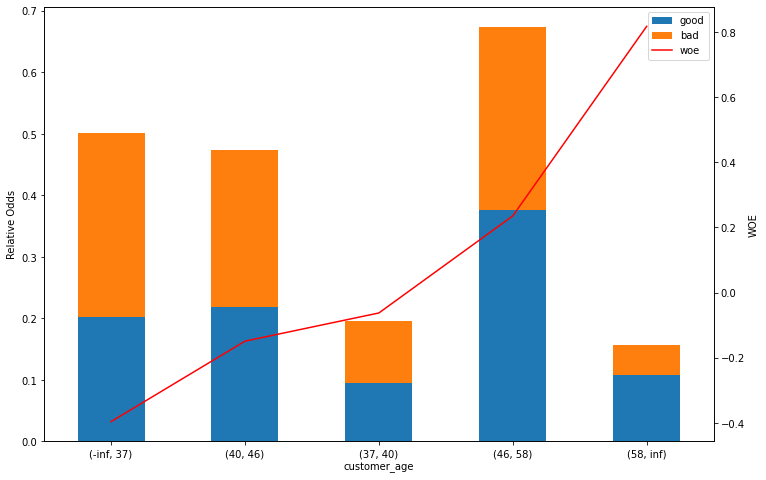

In [21]:
ax = woe_t.woe_mappings["customer_age"].plot.bar(
    x="customer_age", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["customer_age"].plot(
    x="customer_age", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

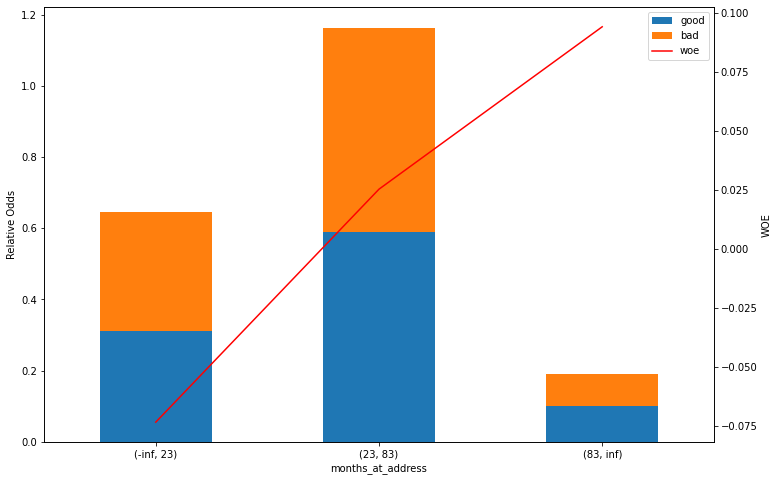

In [22]:
ax = woe_t.woe_mappings["months_at_address"].plot.bar(
    x="months_at_address", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["months_at_address"].plot(
    x="months_at_address", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

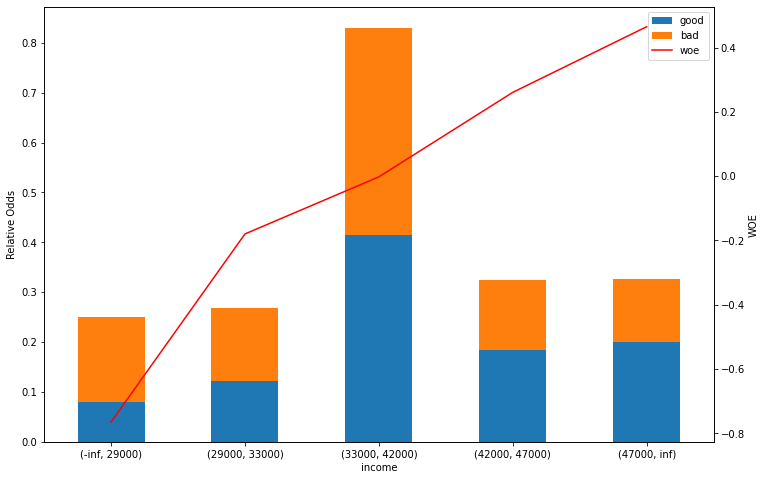

In [23]:
ax = woe_t.woe_mappings["income"].plot.bar(
    x="income", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["income"].plot(
    x="income", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

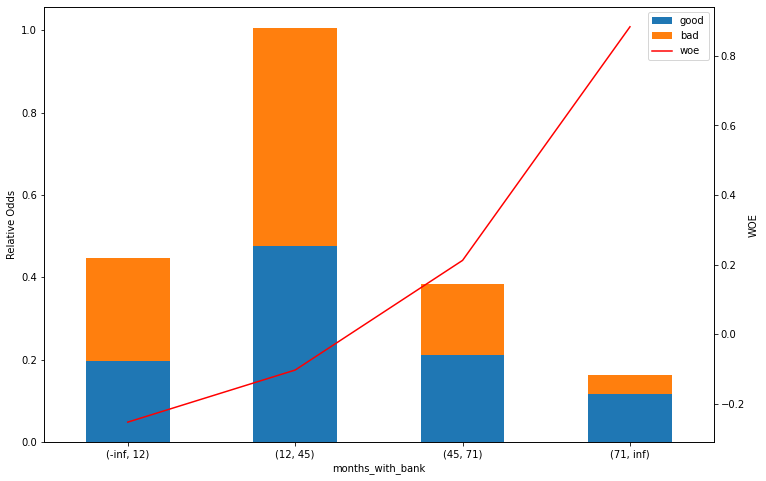

In [24]:
ax = woe_t.woe_mappings["months_with_bank"].plot.bar(
    x="months_with_bank", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["months_with_bank"].plot(
    x="months_with_bank", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

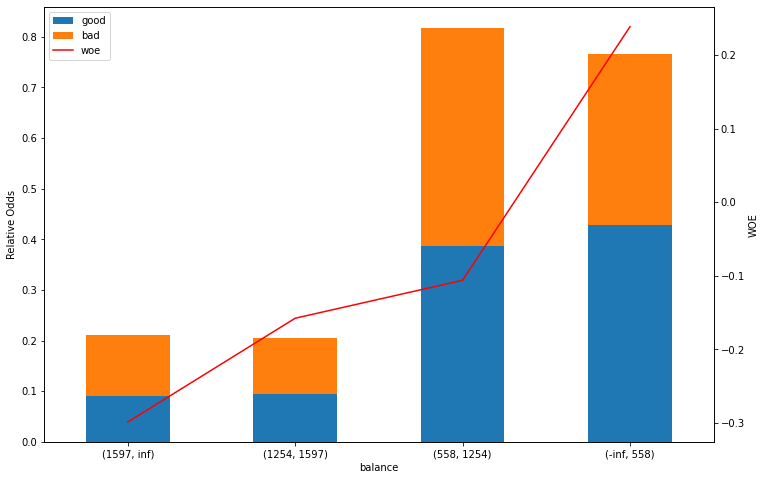

In [25]:
ax = woe_t.woe_mappings["balance"].plot.bar(
    x="balance", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["balance"].plot(
    x="balance", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

# Pipelines

We already defined our custom transformers, and since we added a `fit` and `transform` method, we are able to use `sklearn.pipelines` to stack the transformers and models into a single job that is dealing with raw data. 

In [26]:
ml_pipe = Pipeline([
    ('col selector', ColumnSelectorTransformer(columns=cols_to_keep)),
    ('bins', BinningTransformer(bins=bins)),
    ('woe', WOETransformer(columns=cols_to_keep)),
    # ('logistic regression', LogisticRegression(random_state=seed))
    ('gdbt', GradientBoostingClassifier(random_state=seed))
])

## Target Variable

We change the model to predict the non-default probability.


In [27]:
y_train_nd = [1 if val==0 else 0 for val in y_train.values]

In [28]:
ml_pipe.fit(x_train, y_train_nd)

Pipeline(steps=[('col selector',
                 ColumnSelectorTransformer(['customer_age', 'months_at_address', 'residence_status', 'employment', 'income', 'other_credits', 'months_with_bank', 'balance'])),
                ('bins', BinningTransformer()),
                ('woe',
                 WOETransformer(columns=['customer_age', 'months_at_address', 'residence_status', 'employment', 'income', 'other_credits', 'months_with_bank', 'balance'], target_mappings={0: 'good', 1: 'bad'})),
                ('gdbt', GradientBoostingClassifier(random_state=0))])

In [29]:
ml_pipe.score(x_train, y_train_nd)

0.715

In [30]:
ml_pipe.predict_proba(x_train)

array([[0.20964233, 0.79035767],
       [0.12986429, 0.87013571],
       [0.31834628, 0.68165372],
       ...,
       [0.37199292, 0.62800708],
       [0.18461841, 0.81538159],
       [0.46838573, 0.53161427]])

In [31]:
y_pred = ml_pipe.predict(x_train)

In [32]:
fpr, tpr, threshold = roc_curve(y_train_nd, ml_pipe.predict_proba(x_train)[:, 1])
roc_auc = auc(fpr, tpr)
f1 = f1_score(y_train_nd, y_pred)
print(f"ROC AUC: {roc_auc}")
print(f"F1: {f1}")

ROC AUC: 0.7483978531388904
F1: 0.8139281828073993


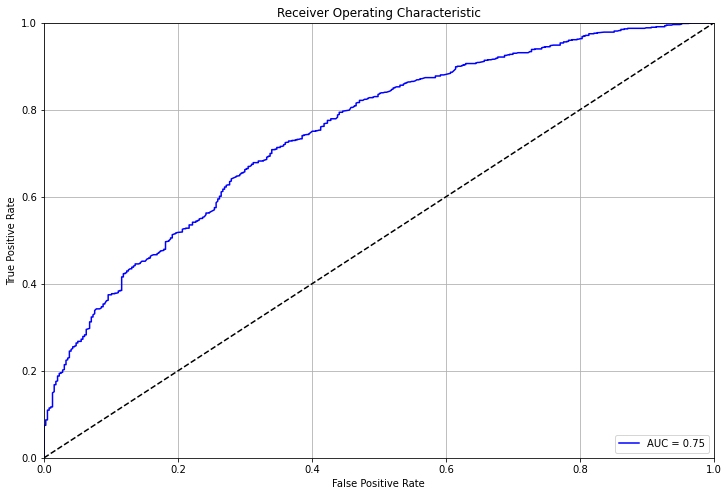

In [33]:
plt.figure(figsize=(12, 8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [34]:
predictions = pd.DataFrame({"y_original": y_train_nd, "y_predicted": ml_pipe.predict_proba(x_train)[:, 1]})
predictions.head()

,y_original,y_predicted
0,1,0.790358
1,1,0.870136
2,1,0.681654
3,1,0.796354
4,1,0.851499


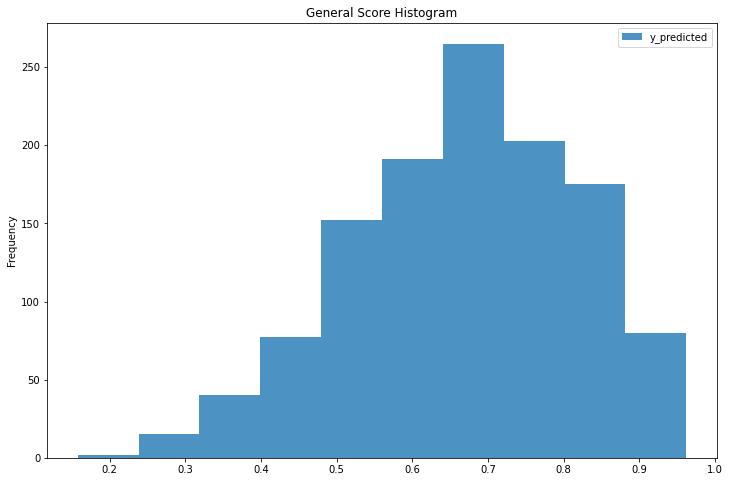

In [35]:
predictions.plot.hist(title="General Score Histogram", y="y_predicted", 
                      bins=10, alpha=0.8, figsize=(12, 8));

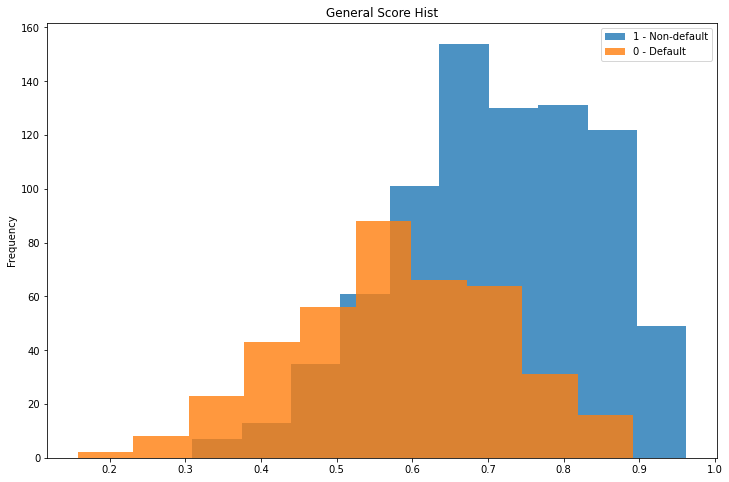

In [36]:
fig, ax = plt.subplots(figsize=(12, 8))

predictions[predictions["y_original"] == 1].plot.hist(title="General Score Hist",
                                                      y="y_predicted",
                                                      bins=10,
                                                      alpha=0.8,
                                                      ax=ax,
                                                      label="1 - Non-default")

predictions[predictions["y_original"] == 0].plot.hist(title="General Score Hist",
                                                      y="y_predicted",
                                                      bins=10,
                                                      alpha=0.8,
                                                      ax=ax,
                                                      label="0 - Default");


In [37]:
predictions[predictions["y_original"] == 0].mean()

y_original     0.000000
y_predicted    0.581252
dtype: float64

In [38]:
predictions[predictions["y_original"] == 1].mean()

y_original     1.000000
y_predicted    0.712568
dtype: float64

Good clients have a slightly bigger skew (0.69), while defaulted clients are less skewed (0.62)

# ##########################################

In [39]:
pd.get_dummies(x_train_b).head()

,"customer_age_(-inf, 37)","customer_age_(37, 40)","customer_age_(40, 46)","customer_age_(46, 58)","customer_age_(58, inf)","months_at_address_(-inf, 23)","months_at_address_(23, 83)","months_at_address_(83, inf)",residence_status_HomeOwner,residence_status_Other,...,other_credits_No,other_credits_Yes,"months_with_bank_(-inf, 12)","months_with_bank_(12, 45)","months_with_bank_(45, 71)","months_with_bank_(71, inf)","balance_(-inf, 558)","balance_(1254, 1597)","balance_(1597, inf)","balance_(558, 1254)"
0,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1
1,0,0,0,0,1,1,0,0,1,0,...,0,1,0,1,0,0,0,0,0,1
2,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1
3,0,0,0,1,0,0,1,0,1,0,...,0,1,0,1,0,0,1,0,0,0
4,0,0,0,0,1,0,1,0,1,0,...,0,1,0,1,0,0,0,0,0,1


In [40]:
model_2 = LogisticRegression(random_state=seed)
model_2.fit(pd.get_dummies(x_train_b), y_train_nd)
model_2.score(pd.get_dummies(x_train_b), y_train_nd)

0.6908333333333333

# ##########################################

In [41]:
lenc = OrdinalEncoder()
lenc.fit(x_train_b);

In [42]:
lenc.transform(x_train_b)

array([[3., 1., 2., ..., 1., 2., 3.],
       [4., 0., 0., ..., 1., 1., 3.],
       [3., 1., 2., ..., 0., 2., 3.],
       ...,
       [0., 1., 0., ..., 1., 2., 0.],
       [3., 1., 2., ..., 1., 2., 3.],
       [2., 1., 2., ..., 1., 1., 3.]])

In [43]:
model_3 = LogisticRegression(random_state=seed)
model_3.fit(lenc.transform(x_train_b), y_train_nd)
model_3.score(lenc.transform(x_train_b), y_train_nd)

0.6716666666666666

# Serialization

In [44]:
ml_pipe

Pipeline(steps=[('col selector',
                 ColumnSelectorTransformer(['customer_age', 'months_at_address', 'residence_status', 'employment', 'income', 'other_credits', 'months_with_bank', 'balance'])),
                ('bins', BinningTransformer()),
                ('woe',
                 WOETransformer(columns=['customer_age', 'months_at_address', 'residence_status', 'employment', 'income', 'other_credits', 'months_with_bank', 'balance'], target_mappings={0: 'good', 1: 'bad'})),
                ('gdbt', GradientBoostingClassifier(random_state=0))])

In [45]:
output = open('logistic_model.pkl', 'wb')
pickle.dump(ml_pipe, output)
output.close()

In [46]:
!ls


CR11 - GLM.pdf                         Untitled.ipynb
CR12- Classification Model Metrics.pdf __pycache__
CR13 - PD Modeling.pdf                 bins.json
DEMO GLM.ipynb                         bins.py
Dealing with credit data.ipynb         credit-dataset.csv
Poisson GLM.ipynb                      logistic_model.pkl
Project 2 - Credit Models.ipynb        wages.csv
Project-NicolasGonzalez.pdf


In [47]:
import pickle
from sklearn.metrics import roc_curve, auc, f1_score


In [48]:
pkl_file = open('logistic_model.pkl', 'rb')
loaded_model = pickle.load(pkl_file)
pkl_file.close()

In [49]:
fpr, tpr, threshold = roc_curve(y_train_nd, loaded_model.predict_proba(x_train)[:, 1])
roc_auc = auc(fpr, tpr)
f1 = f1_score(y_train_nd, y_pred)
print(f"ROC AUC: {roc_auc}")
print(f"F1: {f1}")

ROC AUC: 0.7483978531388904
F1: 0.8139281828073993


# Scorecards